In [192]:
#https://github.com/vinuthags/adversarial_attack
#https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb
%matplotlib inline

In [193]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils


In [194]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)


X_train original shape (60000, 28, 28)
y_train original shape (60000,)


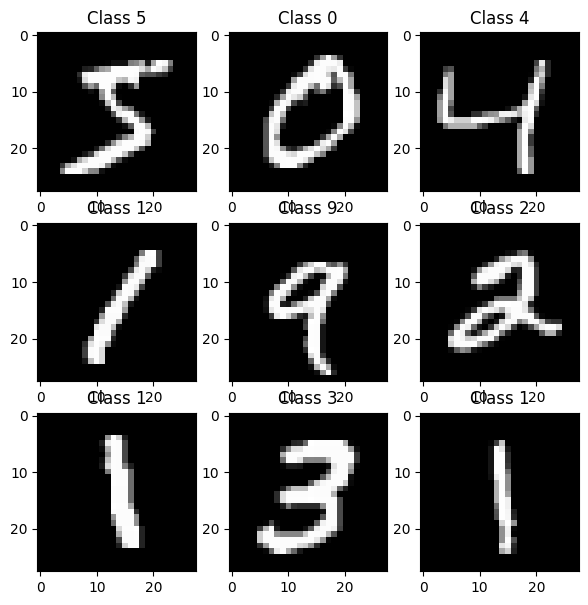

In [195]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))


In [196]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)


Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [197]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


In [198]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.

model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                 # ensures the output is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.

In [199]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [200]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=4, verbose=1,
          validation_data=(X_test, Y_test))


Epoch 1/4
469/469 [==============================] - 5s 9ms/step - loss: 0.2489 - accuracy: 0.9250 - val_loss: 0.1252 - val_accuracy: 0.9626
Epoch 2/4
469/469 [==============================] - 4s 8ms/step - loss: 0.1014 - accuracy: 0.9687 - val_loss: 0.0815 - val_accuracy: 0.9743
Epoch 3/4
469/469 [==============================] - 4s 9ms/step - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.0753 - val_accuracy: 0.9762
Epoch 4/4
469/469 [==============================] - 4s 9ms/step - loss: 0.0554 - accuracy: 0.9820 - val_loss: 0.0706 - val_accuracy: 0.9789


In [201]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0706103965640068
Test accuracy: 0.9789000153541565


In [202]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]


313/313 [==============================] - 1s 2ms/step


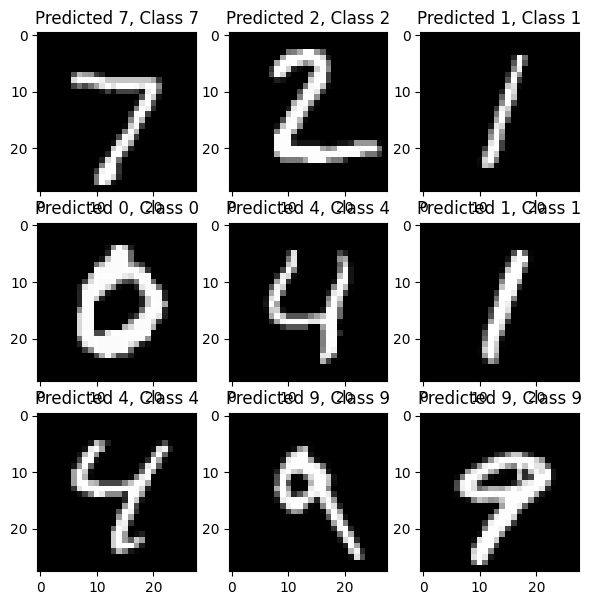

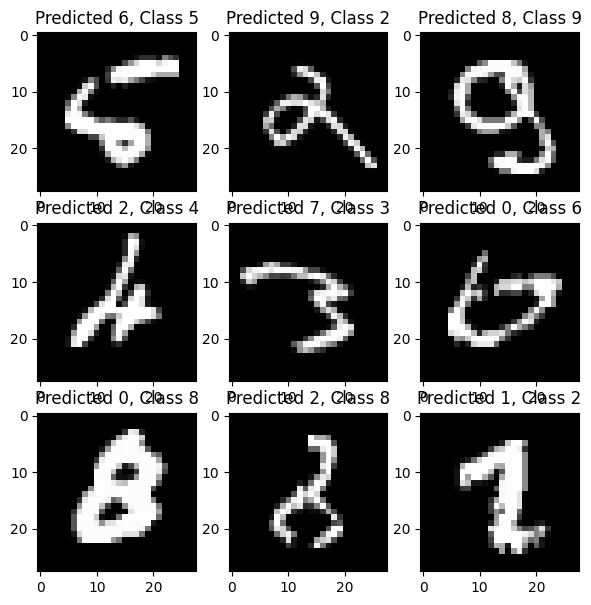

In [203]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))


In [204]:
def createMask(imask,i=0,eps=0.3,noise_coef=0.5):
    id = np.nonzero(y_test==imask)[0][i]
    r_noise = np.random.rand(np.shape(X_test)[1],)
    mask = np.sign(X_test[id] + r_noise * noise_coef) * eps
    return mask,id

Text(0.5, 1.0, 'Пример наложения на 7')

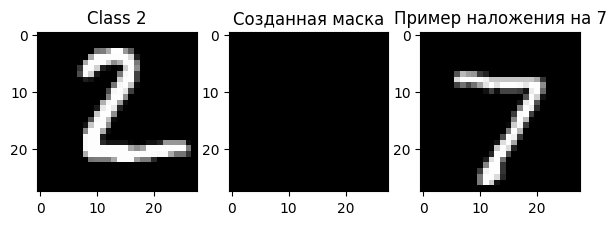

In [205]:
imask = 2
mask,imask = createMask(imask)
iex = 0
plt.subplot(1,3,1)
plt.imshow(X_test[imask].reshape(28,28), cmap='gray', interpolation='none')
plt.title("Class {}".format(y_test[imask]))
plt.subplot(1,3,2)
plt.imshow(mask.reshape(28,28), cmap='gray', interpolation='none')
plt.title("Созданная маска")
plt.subplot(1,3,3)
plt.imshow((mask+X_test[iex]).reshape(28,28), cmap='gray', interpolation='none')
plt.title("Пример наложения на {}".format(y_test[iex]))


In [206]:
xCor = X_test[correct_indices]
yCor = y_test[correct_indices]

In [207]:
def testMask(mask,xtstx):
    tmp = xtstx.copy()
    for i in range(np.shape(xtstx)[0]):
        tmp[i] = xtstx[i] + mask
    return np.argmax(model.predict(tmp), axis=-1)

In [208]:
pc = testMask(mask,xCor)
# Check which items we got right / wrong
corInd = np.nonzero(pc == yCor)[0]
incInd = np.nonzero(pc != yCor)[0]
print('неправильно определено',np.size(incInd))
print('правильно определено',np.size(corInd))

306/306 [==============================] - 1s 2ms/step
неправильно определено 4434
правильно определено 5355


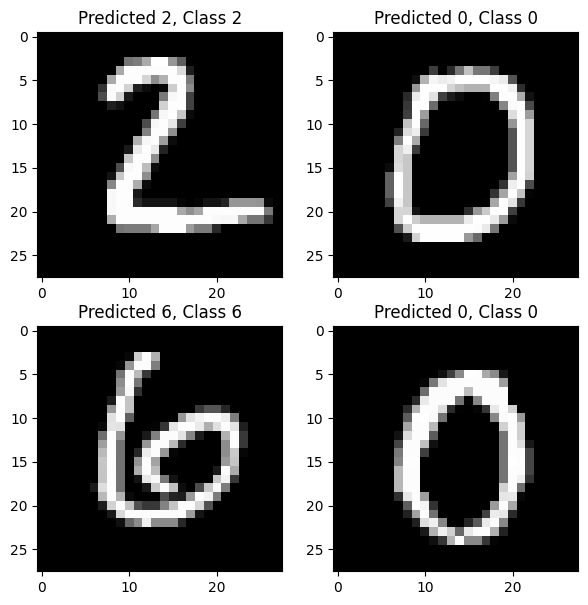

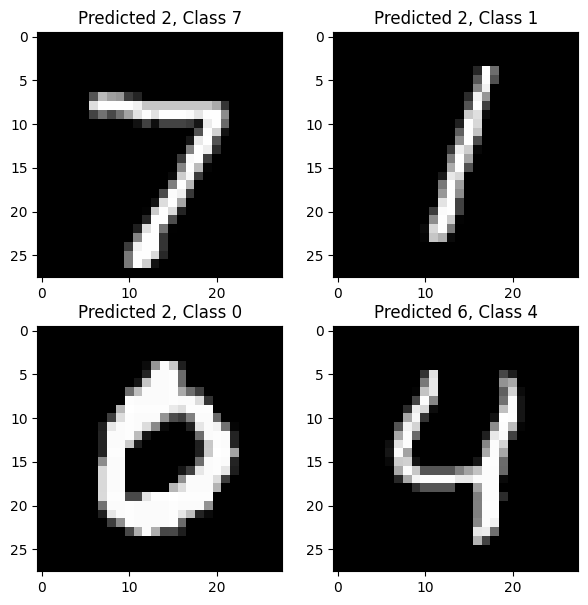

In [209]:
plt.figure()
for i, correct in enumerate(corInd[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(xCor[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(pc[correct], yCor[correct]))

plt.figure()
for i, incorrect in enumerate(incInd[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(xCor[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(pc[incorrect], yCor[incorrect]))

'''
распределение по каждому классу
готовая реализация на resnet обученной на imagenet тоже случайную маску
как работает на рентгенах грудной клетке
https://www.kaggle.com/code/toygarr/resnet-implementation-for-image-classification

=и оценить
мат обоснование
'''

In [210]:
import seaborn as sns

In [211]:
def difByClass(yCor,Ind):
    xdif = np.zeros(10,dtype=np.int32)
    ydif = np.zeros(10,np.int32)
    for i in range(10):
        ydif[i] = np.sum(yCor==i)
        xdif[i] = np.sum(yCor[Ind]==i)
    return xdif/ydif
xtitle = ['0','1','2','3','4','5','6','7','8','9']

<AxesSubplot: >

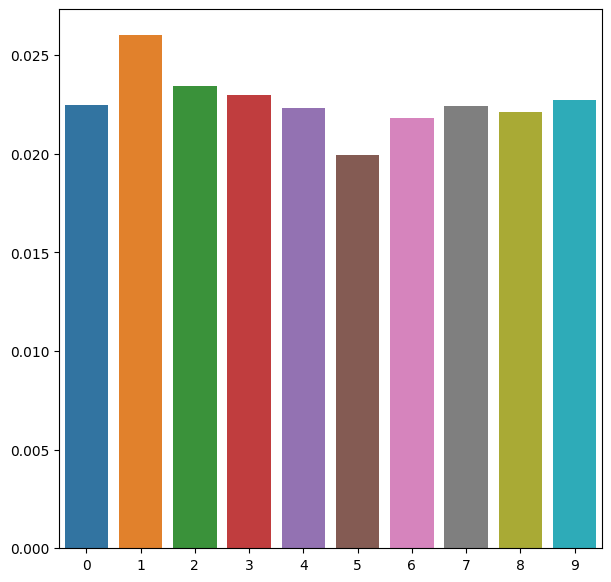

In [221]:
tval = []
for i in range(10):
    tval.append(np.sum(yCor==i)/np.sum(yCor))
sns.barplot(y = tval,x=xtitle)


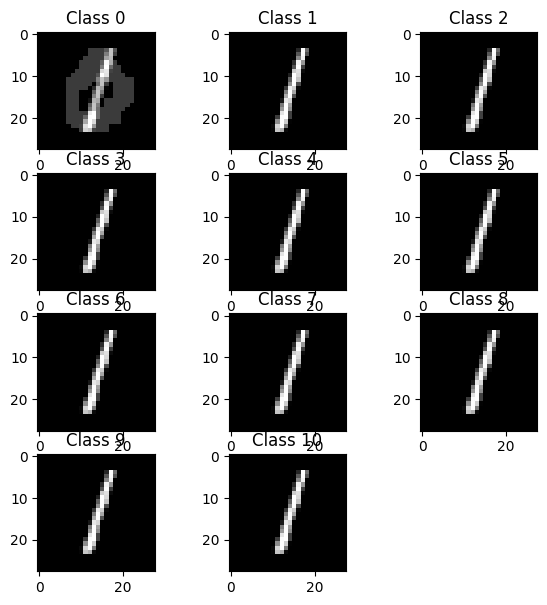

In [246]:
plt.figure()
for i in range(11):
    plt.subplot(4,3,i+1)
    locmask,_ = createMask(0,noise_coef=i/10)
    plt.imshow((xCor[np.nonzero(yCor==1)[0][0]]+locmask).reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Class {}".format(i))

306/306 [==============================] - 1s 2ms/step


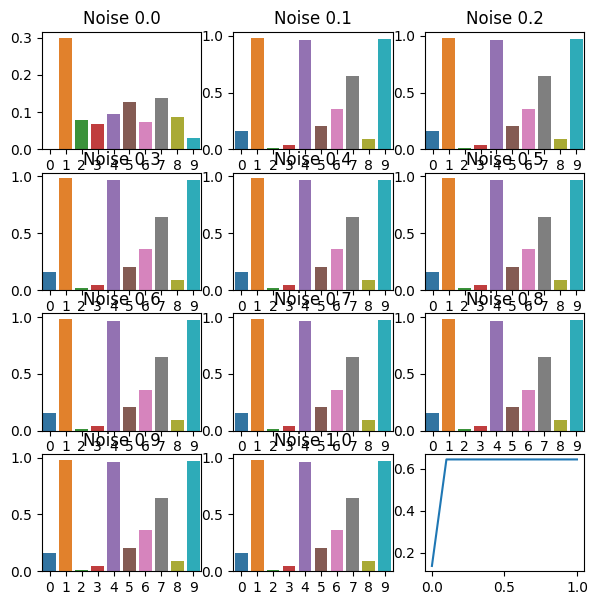

In [269]:
seven = []
xax = []
for i in range(11):
    plt.subplot(4,3,i+1)
    locmask,_ = createMask(0,noise_coef=i/10)
    val = difByClass(yCor,np.nonzero(testMask(locmask,xCor) != yCor)[0])
    sns.barplot(y = val,x=xtitle)
    plt.title("Noise {}".format(i/10))
    seven.append(val[7])
    xax.append(i/10)
plt.subplot(4,3,12)
plt.plot(xax,seven)

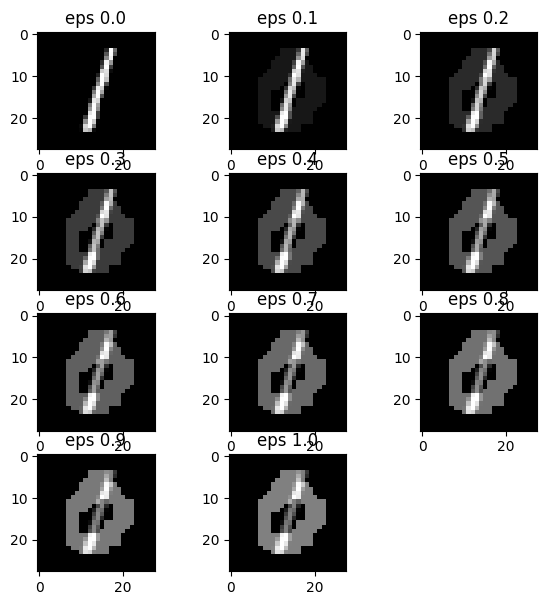

In [249]:
plt.figure()
for i in range(11):
    plt.subplot(4,3,i+1)
    locmask,_ = createMask(0,noise_coef=0,eps=i/10)
    plt.imshow((xCor[np.nonzero(yCor==1)[0][0]]+locmask).reshape(28,28), cmap='gray', interpolation='none')
    plt.title("eps {}".format(i/10))

306/306 [==============================] - 1s 2ms/step


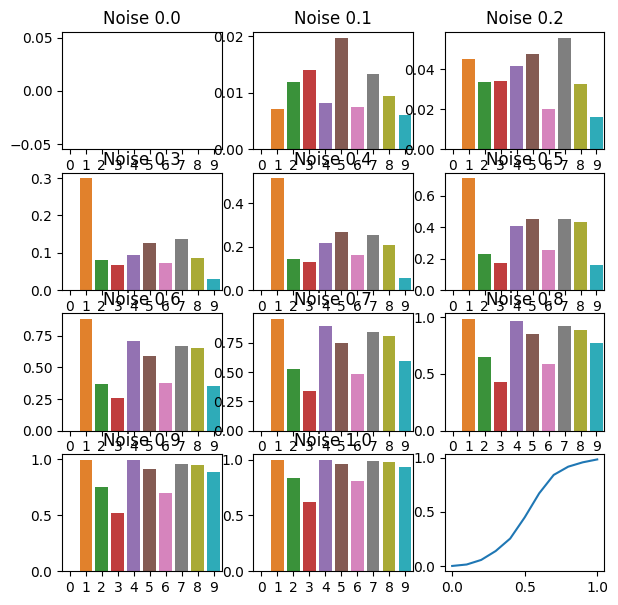

In [271]:
seven = []
xax = []
for i in range(11):
    plt.subplot(4,3,i+1)
    locmask,_ = createMask(0,noise_coef=0,eps=i/10)
    val = difByClass(yCor,np.nonzero(testMask(locmask,xCor) != yCor)[0])
    sns.barplot(y = val,x=xtitle)
    plt.title("Noise {}".format(i/10))
    seven.append(val[7])
    xax.append(i/10)
plt.subplot(4,3,12)
plt.plot(xax,seven)

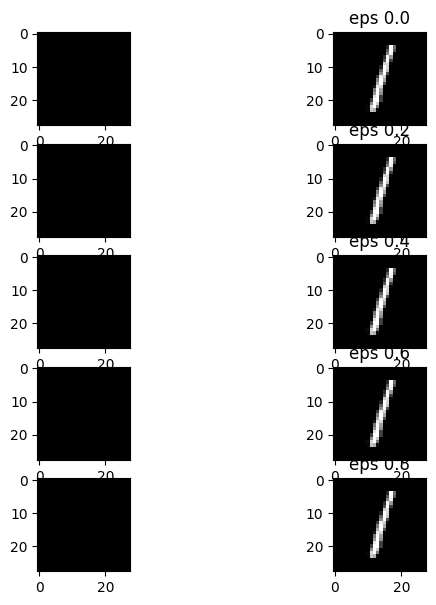

In [264]:

plt.figure()
for i in range(0,10,2):
    plt.subplot(5, 2, i + 1)
    locmask, _ = createMask(0, eps=i / 10)
    plt.imshow((locmask).reshape(28, 28), cmap='gray', interpolation='none')
    plt.subplot(5, 2, i + 2)
    plt.imshow((xCor[np.nonzero(yCor == 1)[0][0]] + locmask).reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("eps {}".format(i / 10))

306/306 [==============================] - 1s 2ms/step


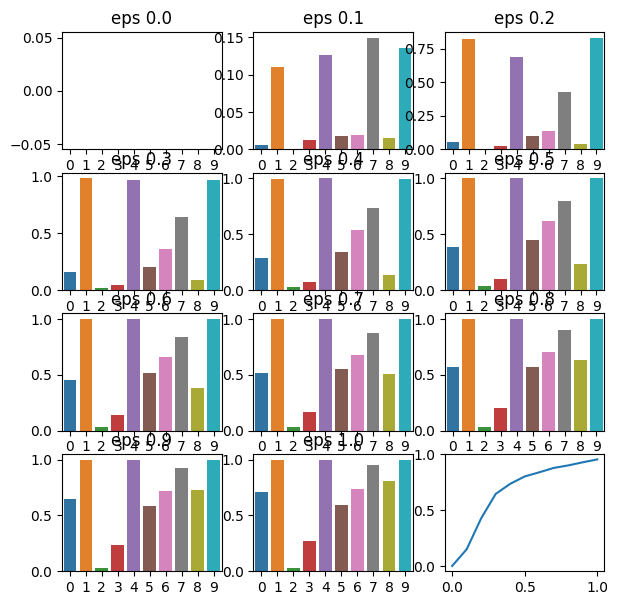

In [268]:
seven = []
xax = []
for i in range(11):
    plt.subplot(4,3,i+1)
    locmask,_ = createMask(0, eps=i / 10)
    val = difByClass(yCor,np.nonzero(testMask(locmask,xCor) != yCor)[0])
    sns.barplot(y = val,x=xtitle)
    plt.title("eps {}".format(i/10))
    seven.append(val[7])
    xax.append(i/10)
plt.subplot(4,3,12)
plt.plot(xax,seven)